In [1]:
import os
import netCDF4 as nc
import numpy as np
import pandas as pd

import copy

import scipy.io as io
import scipy.stats as stats
from scipy import signal
from scipy.stats import mode
from scipy.linalg import eig
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import colors, colorbar
%matplotlib inline
from matplotlib.animation import FuncAnimation
import seaborn as sns

from skimage import measure
from skimage.filters import gaussian

from impdar import *

In [2]:
#files on disk
green_mat = './data/nline5.mat'

#load in data
dat = io.loadmat(green_mat)
data = dat['data']

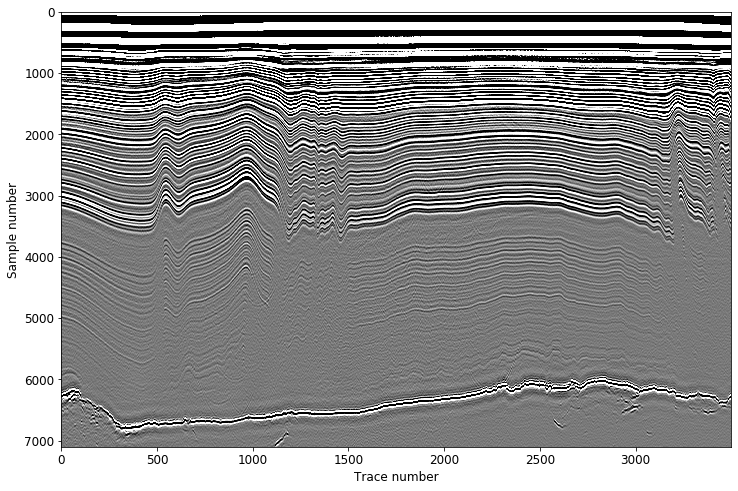

In [3]:
#original image
mini = -8.774235248565674
maxi = 9.667154026031533

fig, ax = plt.subplots(figsize=(12, 8))
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

plt.xlabel('Trace number', fontsize=12)
plt.ylabel('Sample number', fontsize=12)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

### Contouring

In [4]:
#get positive and negative contours
pos = measure.find_contours(data, 3)
neg = measure.find_contours(data, -3)

In [5]:
#save contours and their lengths to lists
c_pos, c_neg, c_length_pos, c_length_neg = [], [], [], []

In [6]:
#positive contours
for contour in pos:
    c_pos.append(contour)
print('Done!\n')

#negative contours
for contour in neg:
    c_neg.append(contour)
print('Done!\n') 

#now extract long contours
#this could be done instead of filtering?
for contour in pos:
    c_length_pos.append(len(contour))
print('Done!\n')
    
for contour in neg:
    c_length_neg.append(len(contour))
print('Done!\n')

Done!

Done!

Done!

Done!



### What we may need is some way to color these contours by power or some similarity metric (coherence?) and not by index (because the contours are not in order).

In [7]:
#find the longest contour
print(np.argmax(c_length_pos))
print(c_length_pos[38])

print(np.argmax(c_length_neg))
print(c_length_neg[298])

#create an iterable list of the contours that are longer than some arbitrary value
long_contours_pos = list(np.where(np.array(c_length_pos) > 500)[0])
long_contours_neg = list(np.where(np.array(c_length_neg) > 500)[0])

470
37
278
113


In [8]:
#isolate some contours
last_long_idx = long_contours_pos[-30:]
last_long_contours = [pos[idx] for idx in last_long_idx]

In [9]:
argx1 = np.argmin(last_long_contours[0][:, 1])
argx2 = np.argmax(last_long_contours[0][:, 1])

In [10]:
print(argx1, argx2)

3 525


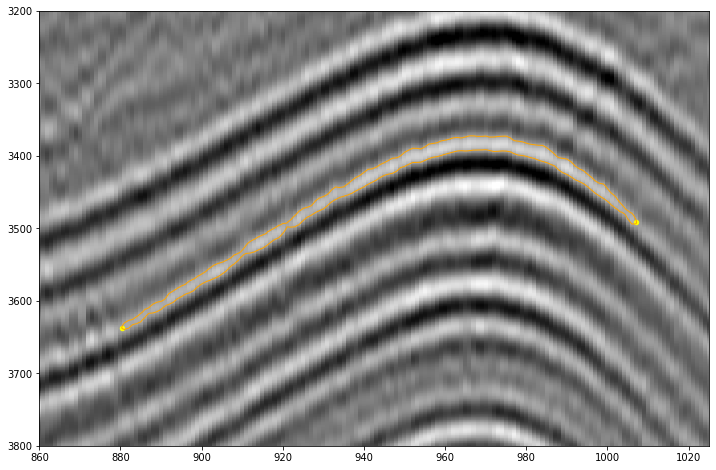

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

plt.plot(last_long_contours[0][:, 1], last_long_contours[0][:, 0], color='orange', linewidth=1)

ax.scatter(last_long_contours[0][argx1, 1], last_long_contours[0][argx1, 0], color='yellow', marker='o', s=20)
ax.scatter(last_long_contours[0][argx2, 1], last_long_contours[0][argx2, 0], color='yellow', marker='o', s=20)

ax.set_xlim([860, 1025])
ax.set_ylim([3800, 3200])
    
plt.show()

In [16]:
saved_x = []
saved_points = []

In [17]:
uniquex = (list(set([int(x) for x in last_long_contours[0][:, 1]])))
print(uniquex)

[880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007]


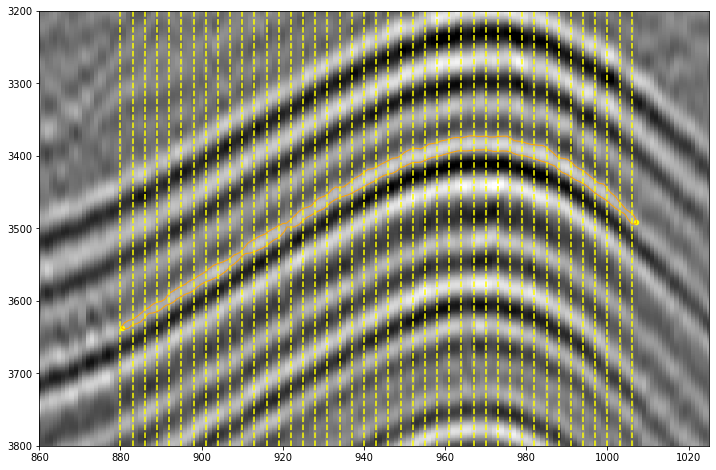

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

plt.plot(last_long_contours[0][:, 1], last_long_contours[0][:, 0], color='orange', linewidth=1)

ax.scatter(last_long_contours[0][argx1, 1], last_long_contours[0][argx1, 0], color='yellow', marker='o', s=20)
ax.scatter(last_long_contours[0][argx2, 1], last_long_contours[0][argx2, 0], color='yellow', marker='o', s=20)

for x in uniquex[::3]:
    ax.axvline(x=x, color='yellow', linestyle='--')

ax.set_xlim([860, 1025])
ax.set_ylim([3800, 3200])
    
plt.show()

In [19]:
delete = []

for i, x in enumerate(uniquex):
    wherex = np.where(last_long_contours[0][:, 1]==x)[0]
    if len(wherex) == 0:
        delete.append(x)
    else:
        if len(wherex) > 2:
            saved_points.append(wherex[1:3])
            print(i, wherex[1:3])
        else:
            saved_points.append(wherex)
            print(i, wherex)
            
uniquex = [x for x in uniquex if x not in delete]

print('\n', len(uniquex))

1 [  10 1010]
2 [  15 1007]
3 [  17 1001]
4 [ 22 999]
5 [ 27 996]
6 [ 34 989]
7 [ 37 982]
8 [ 43 980]
9 [ 47 977]
10 [ 49 973]
11 [ 53 968]
12 [ 62 964]
13 [ 66 961]
14 [ 71 955]
15 [ 75 951]
16 [ 78 946]
17 [ 84 943]
18 [ 87 940]
19 [ 92 933]
20 [ 96 928]
21 [101 924]
22 [107 921]
23 [112 918]
24 [115 914]
25 [118 910]
26 [121 905]
27 [125 898]
28 [131 893]
29 [134 887]
30 [140 880]
31 [148 875]
32 [153 874]
33 [157 871]
34 [162 867]
35 [165 864]
36 [169 859]
37 [174 854]
38 [178 849]
39 [183 845]
40 [186 838]
41 [188 828]
42 [193 826]
43 [200 824]
44 [207 820]
45 [212 814]
46 [215 808]
47 [218 805]
48 [225 800]
49 [230 796]
50 [233 793]
51 [237 787]
52 [244 781]
53 [250 777]
54 [252 773]
55 [254 770]
56 [259 768]
57 [265 764]
58 [270 760]
59 [274 756]
60 [279 752]
61 [284 748]
62 [286 744]
63 [289 740]
64 [294 735]
65 [297 731]
66 [301 729]
67 [305 727]
68 [307 723]
69 [310 717]
70 [316 714]
71 [320 710]
72 [324 707]
73 [325 706]
74 [327 704]
75 [331 701]
76 [336 697]
77 [338 694]
78

In [20]:
print('saved x\n', uniquex[0:10], '\n')
print('saved points\n', saved_points[0:10], '\n')

saved x
 [881, 882, 883, 884, 885, 886, 887, 888, 889, 890] 

saved points
 [array([  10, 1010]), array([  15, 1007]), array([  17, 1001]), array([ 22, 999]), array([ 27, 996]), array([ 34, 989]), array([ 37, 982]), array([ 43, 980]), array([ 47, 977]), array([ 49, 973])] 



In [21]:
print(np.shape(uniquex))
print(np.shape(saved_points))

(127,)
(127, 2)


In [22]:
for i, point in enumerate(saved_points):
    print(i, point)

0 [  10 1010]
1 [  15 1007]
2 [  17 1001]
3 [ 22 999]
4 [ 27 996]
5 [ 34 989]
6 [ 37 982]
7 [ 43 980]
8 [ 47 977]
9 [ 49 973]
10 [ 53 968]
11 [ 62 964]
12 [ 66 961]
13 [ 71 955]
14 [ 75 951]
15 [ 78 946]
16 [ 84 943]
17 [ 87 940]
18 [ 92 933]
19 [ 96 928]
20 [101 924]
21 [107 921]
22 [112 918]
23 [115 914]
24 [118 910]
25 [121 905]
26 [125 898]
27 [131 893]
28 [134 887]
29 [140 880]
30 [148 875]
31 [153 874]
32 [157 871]
33 [162 867]
34 [165 864]
35 [169 859]
36 [174 854]
37 [178 849]
38 [183 845]
39 [186 838]
40 [188 828]
41 [193 826]
42 [200 824]
43 [207 820]
44 [212 814]
45 [215 808]
46 [218 805]
47 [225 800]
48 [230 796]
49 [233 793]
50 [237 787]
51 [244 781]
52 [250 777]
53 [252 773]
54 [254 770]
55 [259 768]
56 [265 764]
57 [270 760]
58 [274 756]
59 [279 752]
60 [284 748]
61 [286 744]
62 [289 740]
63 [294 735]
64 [297 731]
65 [301 729]
66 [305 727]
67 [307 723]
68 [310 717]
69 [316 714]
70 [320 710]
71 [324 707]
72 [325 706]
73 [327 704]
74 [331 701]
75 [336 697]
76 [338 694]
77 

## Now find ridge using x and y bounds

In [23]:
ridge_points = []

In [24]:
for i, point in enumerate(saved_points):
    if(len(point == 2)):
        idx1 = point[0]
        idx2 = point[1]
    elif(len(point > 2)):
        idx1 = point[1]
        idx2 = point[2]
    else:
        raise ValueException("You need to have at least two matching y-values.")
    
    x = uniquex[i]
    
    y1 = int(last_long_contours[0][idx1, 0])
    y2 = int(last_long_contours[0][idx2, 0])
    
    if len(data[y2:y1, x]) == 0:
        print(i, x, np.where(data[:, x] == np.max(data[y1:y2, x]))[0])
        ridge_points.append(np.where(data[:, x] == np.max(data[y1:y2, x]))[0])
    else:
        print(i, x, np.where(data[:, x] == np.max(data[y2:y1, x]))[0])
        ridge_points.append(np.where(data[:, x] == np.max(data[y2:y1, x]))[0])

0 881 [3635]
1 882 [3633]
2 883 [3629]
3 884 [3627]
4 885 [3623]
5 886 [3618]
6 887 [3613]
7 888 [3611]
8 889 [3609]
9 890 [3607]
10 891 [3602]
11 892 [3598]
12 893 [3594]
13 894 [3590]
14 895 [3587]
15 896 [3584]
16 897 [3581]
17 898 [3578]
18 899 [3574]
19 900 [3570]
20 901 [3567]
21 902 [3564]
22 903 [3561]
23 904 [3558]
24 905 [3555]
25 906 [3552]
26 907 [3548]
27 908 [3543]
28 909 [3540]
29 910 [3534]
30 911 [3529]
31 912 [3527]
32 913 [3524]
33 914 [3521]
34 915 [3519]
35 916 [3516]
36 917 [3511]
37 918 [3505]
38 919 [3505]
39 920 [3501]
40 921 [3496]
41 922 [3494]
42 923 [3490]
43 924 [3486]
44 925 [3481]
45 926 [3478]
46 927 [3476]
47 928 [3471]
48 929 [3467]
49 930 [3465]
50 931 [3461]
51 932 [3456]
52 933 [3452]
53 934 [3451]
54 935 [3449]
55 936 [3447]
56 937 [3443]
57 938 [3440]
58 939 [3437]
59 940 [3433]
60 941 [3430]
61 942 [3428]
62 943 [3425]
63 944 [3421]
64 945 [3419]
65 946 [3416]
66 947 [3415]
67 948 [3413]
68 949 [3409]
69 950 [3405]
70 951 [3403]
71 952 [3400]
72

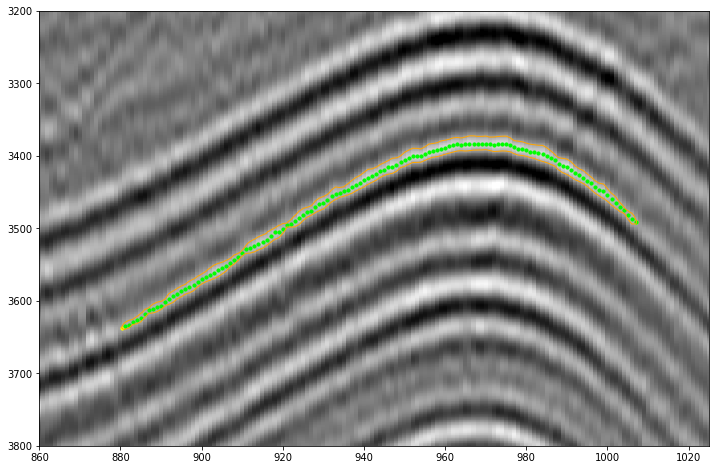

In [25]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

plt.plot(last_long_contours[0][:, 1], last_long_contours[0][:, 0], color='orange', linewidth=1)

ax.scatter(last_long_contours[0][argx1, 1], last_long_contours[0][argx1, 0], color='yellow', marker='o', s=10)
ax.scatter(last_long_contours[0][argx2, 1], last_long_contours[0][argx2, 0], color='yellow', marker='o', s=10)

for i, x in enumerate(uniquex):
    y = ridge_points[i]
    ax.scatter(x, y, color='lime', marker='o', s=10)
    
ax.set_xlim([860, 1025])
ax.set_ylim([3800, 3200])

plt.show()

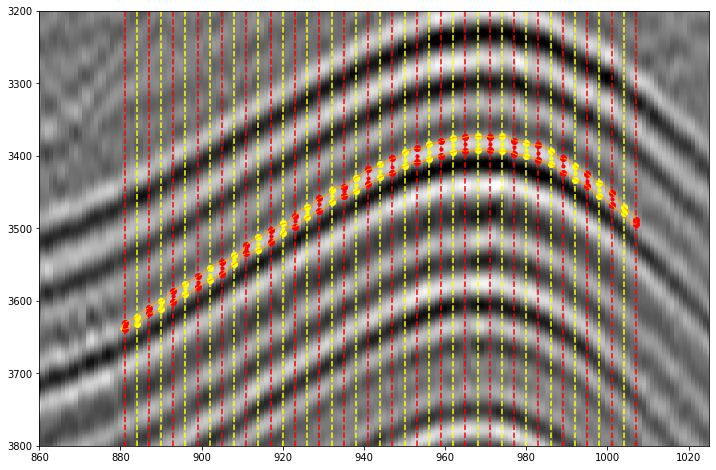

In [26]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))
p = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

plt.plot(last_long_contours[0][:, 1], last_long_contours[0][:, 0], color='orange', linewidth=1)

ax.scatter(last_long_contours[0][argx1, 1], last_long_contours[0][argx1, 0], color='yellow', marker='o', s=10)
ax.scatter(last_long_contours[0][argx2, 1], last_long_contours[0][argx2, 0], color='yellow', marker='o', s=10)

for i, point in enumerate(saved_points[::3]):
        idx1 = point[0]
        idx2 = point[1]
        
        if (i % 2 == 0):
            color='red'
        else:
            color='yellow'
                
        ax.scatter(last_long_contours[0][idx1, 1], last_long_contours[0][idx1, 0], color=color)
        ax.scatter(last_long_contours[0][idx2, 1], last_long_contours[0][idx2, 0], color=color)
        
        ax.scatter(uniquex[::3][i], ridge_points[::3][i], color=color, s=10)
        ax.axvline(uniquex[::3][i], color=color, linestyle='--')

ax.set_xlim([860, 1025])
ax.set_ylim([3800, 3200])
    
#plt.savefig('middle_of_contours1_lines.pdf', type='pdf', bbox_inches='tight')
plt.show()

## Try to animate these points here

In [31]:
#animate TSI agaist both daisy fraction and temperature
def trace_contours(last_long_contours, argx1, argx2, xlims, ylims, ridge_points, saved):
    
    #make plot interactive
    %matplotlib notebook
    #define figure and axis subplots to plot onto

    fig, ax = plt.subplots(figsize=(12, 8))
    #set grid
    grid = ax.imshow(data, cmap='gray', aspect='auto', vmin=mini, vmax=maxi, interpolation='nearest')

    #draw main contour
    ax.plot(last_long_contours[0][:, 1], last_long_contours[0][:, 0], color='orange', linewidth=1)
    
    #add first and last x point to plot
    ax.scatter(last_long_contours[0][argx1, 1], last_long_contours[0][argx1, 0], color='yellow')
    ax.scatter(last_long_contours[0][argx2, 1], last_long_contours[0][argx2, 0], color='yellow')
    
    #add points for top and bottom of contour, as well as for the ridge point
    points1, = ax.plot([], [], color='lime', marker='o')

    #set axis limits (you have to do this explicitly for animations)
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

    #label x and y axes
    ax.set_xlabel('Trace Number')
    ax.set_ylabel('')

    #set subplot titles here
    ax.set_title('Tracing Contours')
    
    
    #the animation function wants an init_func variable
    #so we initialize all lines to blank
    def init():
        points1.set_data([], [])
        
        return points1,


    #to animate, iterate over the 'frames' parameter
    #each 'idx' is a frame
    def animate(idx):
        points1.set_data(saved[0:idx], ridge_points[0:idx])

        return points1,

    #call our animation function
    anim = FuncAnimation(fig, animate, init_func=init, frames=156, interval=25, repeat=True)
    
    return anim

<IPython.core.display.Javascript object>


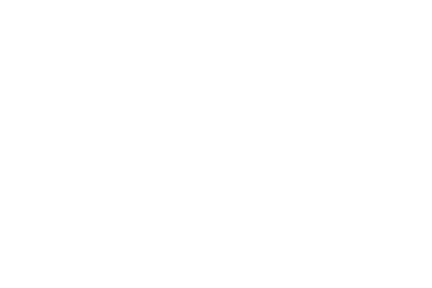

<IPython.core.display.Javascript object>


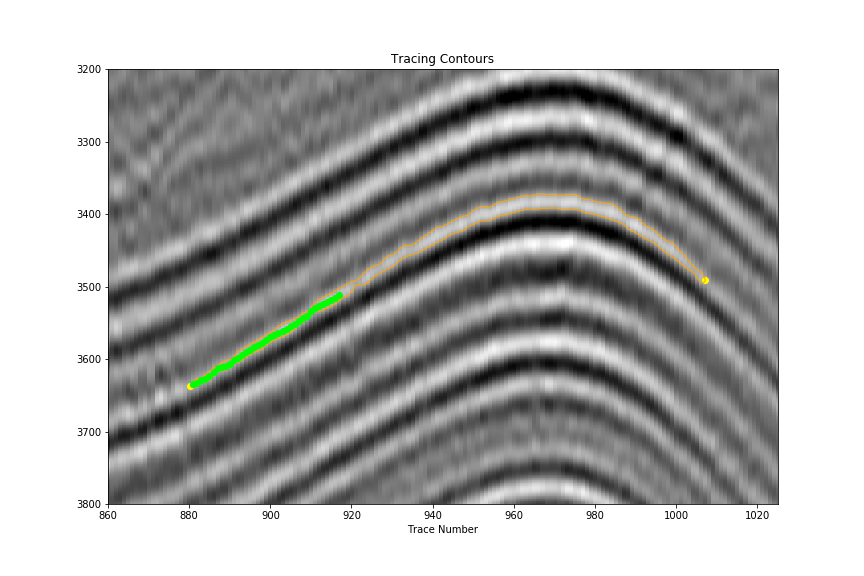

In [33]:
xlims = plt.xlim([860, 1025])
ylims = plt.ylim([3800, 3200])

%matplotlib notebook
trace_contours(last_long_contours, argx1, argx2, xlims, ylims, ridge_points, uniquex)